In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_path = "/content/drive/MyDrive/archive.zip"
data_path = "/content/kvasir_dataset"

!unzip -q $zip_path -d $data_path
!ls $data_path

archive  __MACOSX


In [3]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to dataset
DATA_DIR = "kvasir_dataset/archive"


In [5]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5), # Add random sharpness adjustment
    transforms.RandomAutocontrast(p=0.5), # Add random autocontrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet mean
                         std=[0.229, 0.224, 0.225])   # Imagenet std
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Load dataset
train_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform_test)

# Split dataset (80/20 split)
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Define model - Transfer Learning with ResNet50
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


In [14]:
# Training function
from tqdm.auto import tqdm

def train(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    # Wrap the loader with tqdm for a progress bar
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = correct / total
    return train_loss, train_acc

In [15]:
# Validation function
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        # Wrap the loader with tqdm for a progress bar
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Calculate loss
            running_loss += loss.item() # Accumulate loss
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = correct / total
    avg_loss = running_loss / len(loader) # Calculate average loss
    report = classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes, output_dict=False)
    return acc, report, all_labels, all_preds, avg_loss # Return average loss

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Final evaluation
val_acc, report, y_true, y_pred = evaluate(model, val_loader)
print("\nValidation Accuracy:", val_acc)

# Classification report
print("\nClassification Report:")
print(report)

# Confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

Validation:   0%|          | 0/50 [00:00<?, ?it/s]


Validation Accuracy: 0.92

Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.90      0.95      0.92       182
dyed-resection-margins       0.95      0.92      0.93       206
           esophagitis       0.95      0.70      0.81       208
          normal-cecum       0.93      0.99      0.96       204
        normal-pylorus       0.99      0.98      0.99       182
         normal-z-line       0.77      0.97      0.86       217
                polyps       0.97      0.94      0.95       207
    ulcerative-colitis       0.98      0.93      0.96       194

              accuracy                           0.92      1600
             macro avg       0.93      0.92      0.92      1600
          weighted avg       0.93      0.92      0.92      1600


Confusion Matrix:
[[172  10   0   0   0   0   0   0]
 [ 17 189   0   0   0   0   0   0]
 [  0   0 146   0   1  61   0   0]
 [  0   0   0 201   0   0   2   1]
 [  0   0   1   0 1

In [10]:
# Metrics per class
for i, class_name in enumerate(train_dataset.dataset.classes):
    precision = TP[i] / (TP[i] + FP[i] + 1e-6)
    recall = TP[i] / (TP[i] + FN[i] + 1e-6)
    specificity = TN[i] / (TN[i] + FP[i] + 1e-6)
    accuracy = (TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i] + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\nClass: {class_name}")
    print(f"  TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
    print(f"  Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Save model
torch.save(model.state_dict(), "resnet50_kvasirv2.pth")


Class: dyed-lifted-polyps
  TP: 172, TN: 1398, FP: 20, FN: 10
  Precision: 0.8958, Recall: 0.9451, Specificity: 0.9859
  Accuracy: 0.9812, F1 Score: 0.9198

Class: dyed-resection-margins
  TP: 189, TN: 1384, FP: 10, FN: 17
  Precision: 0.9497, Recall: 0.9175, Specificity: 0.9928
  Accuracy: 0.9831, F1 Score: 0.9333

Class: esophagitis
  TP: 146, TN: 1384, FP: 8, FN: 62
  Precision: 0.9481, Recall: 0.7019, Specificity: 0.9943
  Accuracy: 0.9562, F1 Score: 0.8066

Class: normal-cecum
  TP: 201, TN: 1381, FP: 15, FN: 3
  Precision: 0.9306, Recall: 0.9853, Specificity: 0.9893
  Accuracy: 0.9887, F1 Score: 0.9571

Class: normal-pylorus
  TP: 179, TN: 1416, FP: 2, FN: 3
  Precision: 0.9890, Recall: 0.9835, Specificity: 0.9986
  Accuracy: 0.9969, F1 Score: 0.9862

Class: normal-z-line
  TP: 210, TN: 1320, FP: 63, FN: 7
  Precision: 0.7692, Recall: 0.9677, Specificity: 0.9544
  Accuracy: 0.9562, F1 Score: 0.8571

Class: polyps
  TP: 194, TN: 1387, FP: 6, FN: 13
  Precision: 0.9700, Recall: 0.

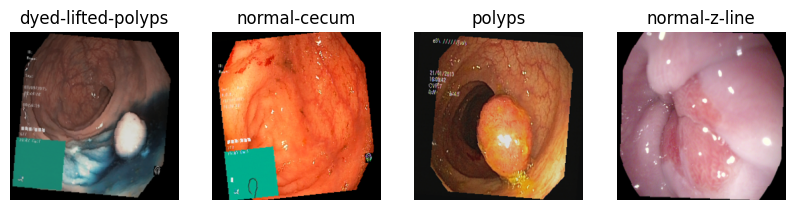

In [11]:
import matplotlib.pyplot as plt
import random

def imshow(img):
    # Unnormalize image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of validation data
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Select a few random images from the batch
num_images_to_show = 4
selected_indices = random.sample(range(images.size(0)), num_images_to_show)

# Display the images
fig = plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    ax = fig.add_subplot(1, num_images_to_show, i + 1, xticks=[], yticks=[])
    imshow(images[selected_indices[i]])
    ax.set_title(train_dataset.dataset.classes[labels[selected_indices[i]]])
plt.show()

# Task
Continue training the model for 5 epochs, unfreezing 10 layers at a time until training is complete. Modify the code to utilize the full GPU RAM. After training, add more metrics, plot the learning curve, display examples of preprocessed images, perform ROC-AUC analysis with visualizations, and enhance model interpretability with visualizations linked to images.

## Implement additional metrics

### Subtask:
Calculate and display additional relevant metrics beyond accuracy and the classification report.


**Reasoning**:
Calculate and print the overall, macro-averaged, and weighted-averaged precision, recall, F1-score, and balanced accuracy using the existing `y_true` and `y_pred` lists.



In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

# Overall metrics (micro average)
overall_precision = precision_score(y_true, y_pred, average='micro')
overall_recall = recall_score(y_true, y_pred, average='micro')
overall_f1 = f1_score(y_true, y_pred, average='micro')

print("\nOverall Metrics (Micro Average):")
print(f"  Precision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, F1 Score: {overall_f1:.4f}")

# Macro-averaged metrics
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

print("\nMacro-averaged Metrics:")
print(f"  Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1 Score: {macro_f1:.4f}")

# Weighted-averaged metrics
weighted_precision = precision_score(y_true, y_pred, average='weighted')
weighted_recall = recall_score(y_true, y_pred, average='weighted')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

print("\nWeighted-averaged Metrics:")
print(f"  Precision: {weighted_precision:.4f}, Recall: {weighted_recall:.4f}, F1 Score: {weighted_f1:.4f}")

# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")


Overall Metrics (Micro Average):
  Precision: 0.9200, Recall: 0.9200, F1 Score: 0.9200

Macro-averaged Metrics:
  Precision: 0.9288, Recall: 0.9214, F1 Score: 0.9211

Weighted-averaged Metrics:
  Precision: 0.9270, Recall: 0.9200, F1 Score: 0.9193

Balanced Accuracy: 0.9214


## Plot the learning curve

### Subtask:
Track and plot the training and validation loss and accuracy over epochs to visualize the learning process.


**Reasoning**:
Initialize lists to store loss and accuracy values, then modify the training and evaluation loops to append these values after each epoch. Finally, plot the collected data.



Initial training...


Epochs (initial training):   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0624, Val Accuracy: 0.9219


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0528, Val Accuracy: 0.9019


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0584, Val Accuracy: 0.9106


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0439, Val Accuracy: 0.9175


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0416, Val Accuracy: 0.9250

Fine-tuning with last 10 layers unfrozen...


Epochs (fine-tuning):   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0507, Val Accuracy: 0.9225


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0429, Val Accuracy: 0.9213


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0278, Val Accuracy: 0.9113


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0521, Val Accuracy: 0.9206


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0368, Val Accuracy: 0.9250


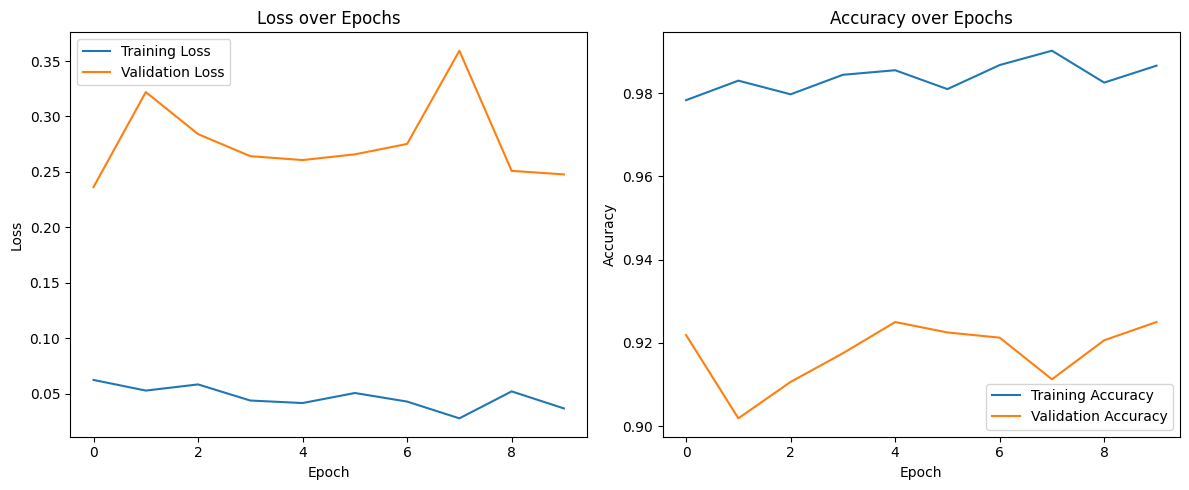

In [16]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
EPOCHS = 5  # Train for 5 more epochs
print("Initial training...")
for epoch in tqdm(range(EPOCHS), desc="Epochs (initial training)"):
    loss, acc = train(model, train_loader) # Get both loss and accuracy from train
    val_acc, _, _, _, val_loss = evaluate(model, val_loader) # Get validation accuracy and loss from evaluate

    # Record metrics
    train_losses.append(loss)
    val_losses.append(val_loss) # Record validation loss
    train_accuracies.append(acc) # Record training accuracy
    val_accuracies.append(val_acc)


    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Unfreeze last 10 layers
for param in list(model.parameters())[-10:]:
    param.requires_grad = True

# Continue training for another 5 epochs with unfrozen layers
EPOCHS_FINE_TUNE = 5
print("\nFine-tuning with last 10 layers unfrozen...")
for epoch in tqdm(range(EPOCHS_FINE_TUNE), desc="Epochs (fine-tuning)"):
    loss, acc = train(model, train_loader) # Get both loss and accuracy from train
    val_acc, _, _, _, val_loss = evaluate(model, val_loader) # Get validation accuracy and loss from evaluate

    # Record metrics
    train_losses.append(loss)
    val_losses.append(val_loss) # Record validation loss
    train_accuracies.append(acc) # Record training accuracy
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS_FINE_TUNE}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Plotting the learning curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS + EPOCHS_FINE_TUNE), train_losses, label='Training Loss')
plt.plot(range(EPOCHS + EPOCHS_FINE_TUNE), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS + EPOCHS_FINE_TUNE), train_accuracies, label='Training Accuracy')
plt.plot(range(EPOCHS + EPOCHS_FINE_TUNE), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Display examples of preprocessed images

### Subtask:
Display several examples of images after applying the training transformations.